In [1]:
#import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

from torch.utils.tensorboard import SummaryWriter


In [2]:
#import dataset
df = pd.read_csv('dataset-ml-25m/dataset.csv')

### Data Prepocessing

In [3]:
#split data and labels 
X = df.drop(['rating'], axis=1)
y = df['rating']

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)
#count the numebr of x_train 
print("Number of train set: ", X_train.shape[0])
print("Number of validation set: ", X_val.shape[0])
print("Numebr of test set: ", X_test.shape[0])

Number of train set:  10362
Numebr of test set:  3454


In [4]:
# T-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=500)
X_train_tsne = tsne.fit_transform(X_train)


/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


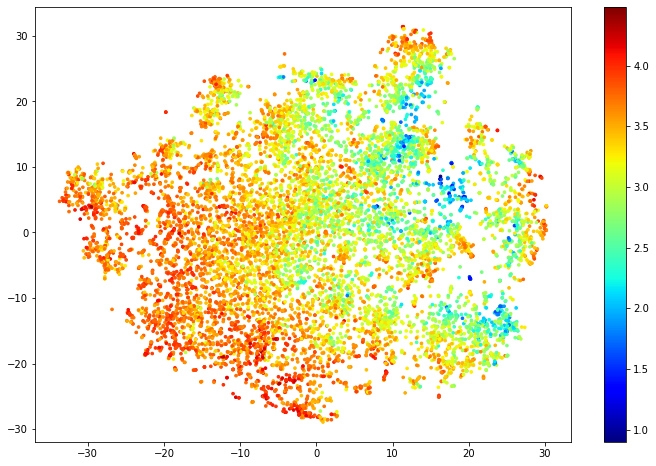

In [5]:
plt.figure(figsize=(12, 8))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap="jet", s=7)
plt.colorbar()

plt.show()

### Linear Regressor

In [6]:
log_name = f"linear_regression"
writer = SummaryWriter(f"results/tradML/no_pca/LinearRegression/{log_name}")

lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)
y_pred = lin_regr.predict(X_test)

# Compute the RSS
mse = mean_squared_error(y_test, y_pred) 
print('Mean Square Error:', mse)
writer.add_scalar('Loss', mse)
writer.flush()

# Compute the R-square index
rsquare = r2_score(y_test, y_pred) 
print('R-square:', rsquare)


Mean Square Error: 0.0053672274121675445
R-square: 0.9759840735510301


### Random Forest Regressor
TEST SET
Mean Squared Error:  0.03662117019915541

R2 Score:  0.8361367494911226

iper con pca = 30 e quared_error
91 min


In [7]:
param_grid = {
                "n_estimators": [10, 15, 20, 25, 30],
                "criterion": ["squared_error", "friedman_mse"]
              }
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)
best_no_leaves= grid_search.best_params_
print("Best number of leaves: ", best_no_leaves)



Best number of leaves:  {'criterion': 'squared_error', 'n_estimators': 25}


In [8]:
display(grid_search.cv_results_)
#save into csv grid_search.cv_results_
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/no_pca/RandomForestRegressor.csv")

{'mean_fit_time': array([ 45.43057928,  68.72359304,  91.35921144, 114.14897776,
        136.9380486 ,  46.27426653,  69.80956197,  93.05771523,
        116.13068876, 139.84805608]),
 'std_fit_time': array([0.16834292, 0.21862845, 0.30274024, 0.61502666, 0.50944773,
        0.15763835, 0.27932941, 0.3847386 , 0.42255455, 0.52353048]),
 'mean_score_time': array([0.02427745, 0.02807679, 0.03265376, 0.03860726, 0.04167442,
        0.02426763, 0.03095803, 0.03635817, 0.03733721, 0.04260492]),
 'std_score_time': array([0.00210084, 0.00144656, 0.0010321 , 0.00157746, 0.00249494,
        0.00194078, 0.00199171, 0.00572846, 0.00141136, 0.00153132]),
 'param_criterion': masked_array(data=['squared_error', 'squared_error', 'squared_error',
                    'squared_error', 'squared_error', 'friedman_mse',
                    'friedman_mse', 'friedman_mse', 'friedman_mse',
                    'friedman_mse'],
              mask=[False, False, False, False, False, False, False, False,
         

In [9]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_n_estimators', 'param_criterion', 'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/no_pca/RandomForest/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    n_estimators = row['param_n_estimators']
    criterion = row['param_criterion']
    writer.add_hparams({"n_estimators": n_estimators, "criterion": criterion},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [11]:
rf = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
rf = rf.T
rf.to_csv('best_params/no_pca/random_forest.csv', index=False)

In [12]:
rf = RandomForestRegressor(n_estimators = 30, criterion = "squared_error")
rf= rf.fit(X_train,y_train)

y_pred= rf.predict(X_test)
print ("TEST SET")
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))


TEST SET
Mean Squared Error:  0.012290356766490203
R2 Score:  0.9450061863474448


### Ridge Regressor
Mean Squared Error:  0.006422342939029505

R2 Score:  0.9712629065606324

In [13]:
param_grid = {
                "alpha":[0.0001, 0.001, 0.1, 0.5, 1, 5, 10, 20]
              }
ridge = Ridge()
ridge.fit(X_train,y_train)
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
#display(grid_search.cv_results_)
best_hyper= grid_search.best_params_
print("Best number of leaves: ", best_hyper)
#save into csv grid_search.cv_results_
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/no_pca/Ridge.csv")

Best number of leaves:  {'alpha': 5}


In [14]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_alpha','mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/no_pca/Ridge")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    alpha = row['param_alpha']
    writer.add_hparams({"alpha": alpha},{"/hparam/mse": mse})
    writer.flush()
writer.close()

In [15]:
ridge = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
ridge = ridge.T
ridge.to_csv('best_params/no_pca/ridge.csv', index=False)

In [16]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

print("TEST SET")
y_pred= ridge.predict(X_test)
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))


TEST SET
Mean Squared Error:  0.005357611236198246
R2 Score:  0.9760271016094789


### KNN Regressor
Mean Squared Error:  0.04392172471123978

R2 Score:  0.8034700546159548

In [17]:
param_grid = {
                'n_neighbors': [3, 4, 5, 7, 8, 9, 10],
                'weights': ['uniform', 'distance']
              }
knn = KNeighborsRegressor()
knn.fit(X_train,y_train)
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
best_hyper= grid_search.best_params_
print("Best number of leaves: ", best_hyper)

Best number of leaves:  {'n_neighbors': 10, 'weights': 'distance'}


In [18]:
display(grid_search.cv_results_)
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/no_pca/KNN.csv")

{'mean_fit_time': array([0.03775048, 0.03447618, 0.03335061, 0.03504643, 0.03405094,
        0.0348505 , 0.03544941, 0.03195457, 0.03573875, 0.03359008,
        0.03471193, 0.03374305, 0.03586054, 0.03362775]),
 'std_fit_time': array([0.00483891, 0.00130659, 0.00276591, 0.00244019, 0.00135163,
        0.00319406, 0.00484828, 0.0006836 , 0.00546948, 0.00192342,
        0.00297285, 0.0020596 , 0.00202668, 0.00205017]),
 'mean_score_time': array([0.63852267, 0.60690732, 0.66345663, 0.65547757, 0.66772175,
        0.66080742, 0.66348677, 0.67056837, 0.65609279, 0.66135097,
        0.6492105 , 0.66887598, 0.64884653, 0.66482263]),
 'std_score_time': array([0.04353535, 0.0135709 , 0.01397749, 0.0053401 , 0.01777008,
        0.01565102, 0.01535188, 0.01316007, 0.01463603, 0.01358286,
        0.00339494, 0.02240341, 0.00453602, 0.01490369]),
 'param_n_neighbors': masked_array(data=[3, 3, 4, 4, 5, 5, 7, 7, 8, 8, 9, 9, 10, 10],
              mask=[False, False, False, False, False, False, False,

In [19]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_n_neighbors', 'param_weights', 'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/no_pca/KNN/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    n_neighbors = row['param_n_neighbors']
    weights = row['param_weights']
    writer.add_hparams({"n_neighbors": n_neighbors, "weights":weights},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [20]:
knn = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
knn = knn.T
knn.to_csv('best_params/no_pca/knn.csv', index=False)

In [21]:
knn = KNeighborsRegressor(n_neighbors= 10, weights= 'distance')
knn.fit(X_train, y_train)

print("TEST SET")
y_pred= knn.predict(X_test)
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

TEST SET
Mean Squared Error:  0.040832624087876704
R2 Score:  0.8172923892530098


### Lasso Regressor

Mean Squared Error:  0.006402684362671739

R2 Score:  0.971350869839928

In [22]:
param_grid = {
                'alpha':[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
              }
lasso = Lasso()
lasso.fit(X_train,y_train)
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
best_hyper= grid_search.best_params_
print("Best values - Hyperparameters: ", best_hyper)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.673e+00, tolerance: 1.971e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.848e+00, tolerance: 1.998e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.947e+00, tolerance: 1.974e-01

Best values - Hyperparameters:  {'alpha': 1e-05}


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.115e+01, tolerance: 2.465e-01
  model = cd_fast.enet_coordinate_descent(


In [23]:
display(grid_search.cv_results_)
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/no_pca/Lasso.csv")

{'mean_fit_time': array([0.11212649, 0.38945241, 1.09806051, 6.00091801, 7.4668098 ,
        7.81209974]),
 'std_fit_time': array([0.00357718, 0.02143566, 0.03838263, 0.03552336, 0.04799182,
        0.0589462 ]),
 'mean_score_time': array([0.01131835, 0.01107659, 0.01003966, 0.01047034, 0.0089756 ,
        0.00942678]),
 'std_score_time': array([0.00171256, 0.00213332, 0.0023071 , 0.0023619 , 0.00128178,
        0.00252399]),
 'param_alpha': masked_array(data=[0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.1},
  {'alpha': 0.01},
  {'alpha': 0.001},
  {'alpha': 0.0001},
  {'alpha': 1e-05},
  {'alpha': 1e-06}],
 'split0_test_score': array([-0.23823888, -0.03218666, -0.01046243, -0.00566845, -0.00538772,
        -0.0054746 ]),
 'split1_test_score': array([-0.22554681, -0.03101019, -0.01026276, -0.00536873, -0.0051579 ,
        -0.00524252]),
 'split2_test_sc

In [24]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_alpha','mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/no_pca/Lasso/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    alpha = row['param_alpha']
    writer.add_hparams({"alpha": alpha},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [25]:
lasso = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
lasso= lasso.T
lasso.to_csv('best_params/no_pca/lasso.csv', index=False)

In [26]:
lasso = Lasso(alpha = 1e-05)
lasso.fit(X_train, y_train)

print("TEST SET")
y_pred= lasso.predict(X_test)
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

TEST SET
Mean Squared Error:  0.0053459256594491225
R2 Score:  0.9760793893048139


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.115e+01, tolerance: 2.465e-01
  model = cd_fast.enet_coordinate_descent(


### SVR

Mean Squared Error:  0.0064680272514056085

R2 Score:  0.9710584898289305

51m

In [27]:
param_grid = {
                'kernel': ['linear', 'poly', 'rbf'],
                'epsilon': [0.001, 0.01, 0.1, 1]
              }
svr = SVR()
svr.fit(X_train,y_train)
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
best_hyper = grid_search.best_params_
print("Best values - Hyperparameters: ", best_hyper)

Best values - Hyperparameters:  {'epsilon': 0.001, 'kernel': 'rbf'}


In [28]:
display(grid_search.cv_results_)
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/no_pca/SVR.csv")

In [29]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_kernel','param_epsilon' ,'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1


#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/no_pca/SVR/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    kernel = row['param_kernel']
    epsilon = row['param_epsilon']
    writer.add_hparams({"kernel": kernel, "epsilon":epsilon},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [30]:
svr = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
svr = svr.T
svr.to_csv('best_params/no_pca/svr.csv', index=False)

In [31]:
svr = SVR(kernel ='linear', epsilon = 0.01)
svr.fit(X_train, y_train)

print("TEST SET")
y_pred= svr.predict(X_test)
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

TEST SET
Mean Squared Error:  0.005516429084093021
R2 Score:  0.9753164632368291
